### Spark Moive Recommendation

In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import databricks.koalas as ks

from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, FloatType
from mpl_toolkits.mplot3d import Axes3D
from pyspark.sql.functions import udf

import warnings
warnings.filterwarnings("ignore")

In [1]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

## Part 1: Data ETL and Data Exploration

In [3]:
from pyspark.sql import SparkSession

# A SparkSession can be used create DataFrame, register DataFrame as tables,
# execute SQL over tables, cache tables, and read parquet files.
# Sets a name for the application, which will be shown in the Spark web UI.
spark = SparkSession \
    .builder \
    .appName("Moive Recommend System Analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
movies_df = spark.read.load('ml-latest-small/movies.csv', format='csv', header = True)
ratings_df = spark.read.load('ml-latest-small/ratings.csv', format='csv', header = True)
links_df = spark.read.load('ml-latest-small/links.csv', format='csv', header = True)
tags_df = spark.read.load('ml-latest-small/tags.csv', format='csv', header = True)

In [5]:
movies_df.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [6]:
movies_df.count()

9742

In [7]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [8]:
ratings_df.count()

100836

In [9]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [10]:
links_df.count()

9742

In [11]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [12]:
tags_df.count()

3683

In [13]:
print("If there is missing data in each table?")
print('movie_df: {}'.format(movies_df.count() == movies_df.na.drop().count()))
print('ratings_df: {}'.format(ratings_df.count() == ratings_df.na.drop().count()))
print('links_df: {}'.format(links_df.count() == links_df.na.drop().count()))
print('tags_df: {}'.format(tags_df.count() == tags_df.na.drop().count()))

If there is missing data in each table?
movie_df: True
ratings_df: True
links_df: False
tags_df: True


In [14]:
tmp1 = ratings_df.groupBy("userID").count().select('count').rdd
tmp1.take(5)

[Row(count=27), Row(count=22), Row(count=360), Row(count=34), Row(count=152)]

In [15]:
# Convert df into an RDD
# RDD之后就变成list了，[0]就是第一个元素
tmp1 = ratings_df.groupBy("userID").count().select('count').rdd.min()[0]
tmp2 = ratings_df.groupBy("movieId").count().select('count').rdd.min()[0]
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [16]:
tmp1 = ratings_df.groupBy("movieId").count().filter('count = 1').count()
tmp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user


<AxesSubplot:title={'center':'Distribution of number of ratings (per user)'}, xlabel='number of ratings', ylabel='percentage'>

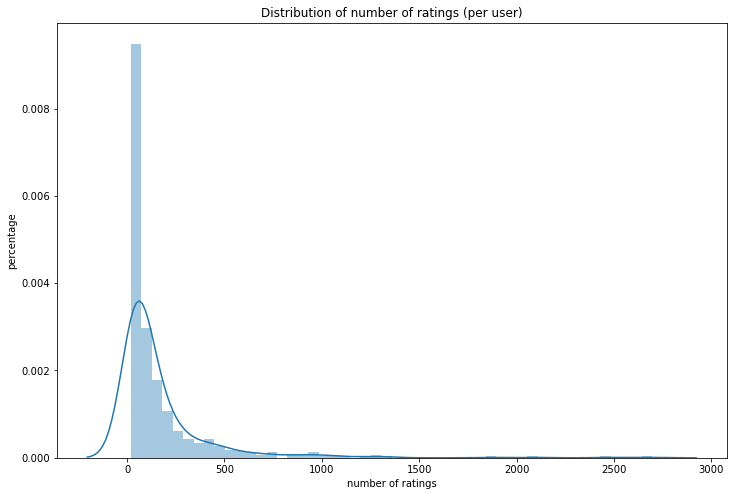

In [17]:
# get statistics for users
users_result = ratings_df.groupBy("userId").count().orderBy('count', ascending=False)

fig = plt.figure(figsize=(12,8))
tmp = sns.distplot(users_result.toPandas()['count'], hist=True)
plt.ylabel('percentage')
plt.xlabel('number of ratings')
tmp.set_title('Distribution of number of ratings (per user)')
display(tmp)

<AxesSubplot:title={'center':'Distribution of number of ratings (per movie)'}, xlabel='number of ratings', ylabel='percentage'>

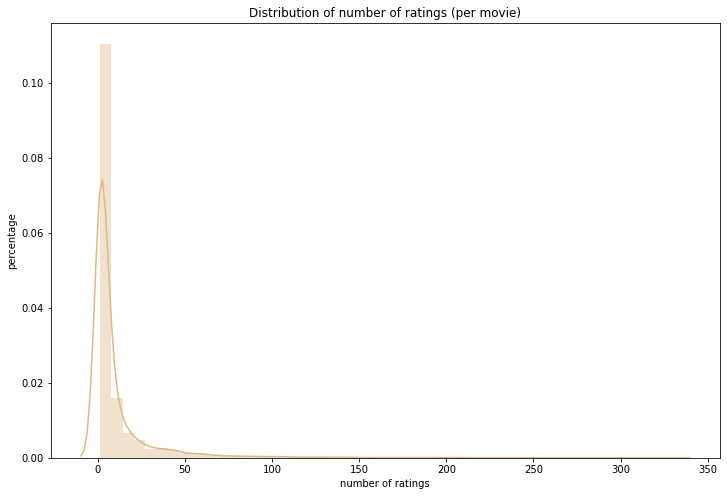

In [18]:
# get statistics for movies
movies_result=ratings_df.groupBy("movieId").count().orderBy('count', ascending=False)

fig = plt.figure(figsize=(12,8))
tmp = sns.distplot(movies_result.toPandas()['count'], color = 'burlywood', hist=True)
plt.ylabel('percentage')
plt.xlabel('number of ratings')
tmp.set_title('Distribution of number of ratings (per movie)')
display(tmp)

<AxesSubplot:title={'center':'Number of movies of each category'}, xlabel='genres', ylabel='count'>

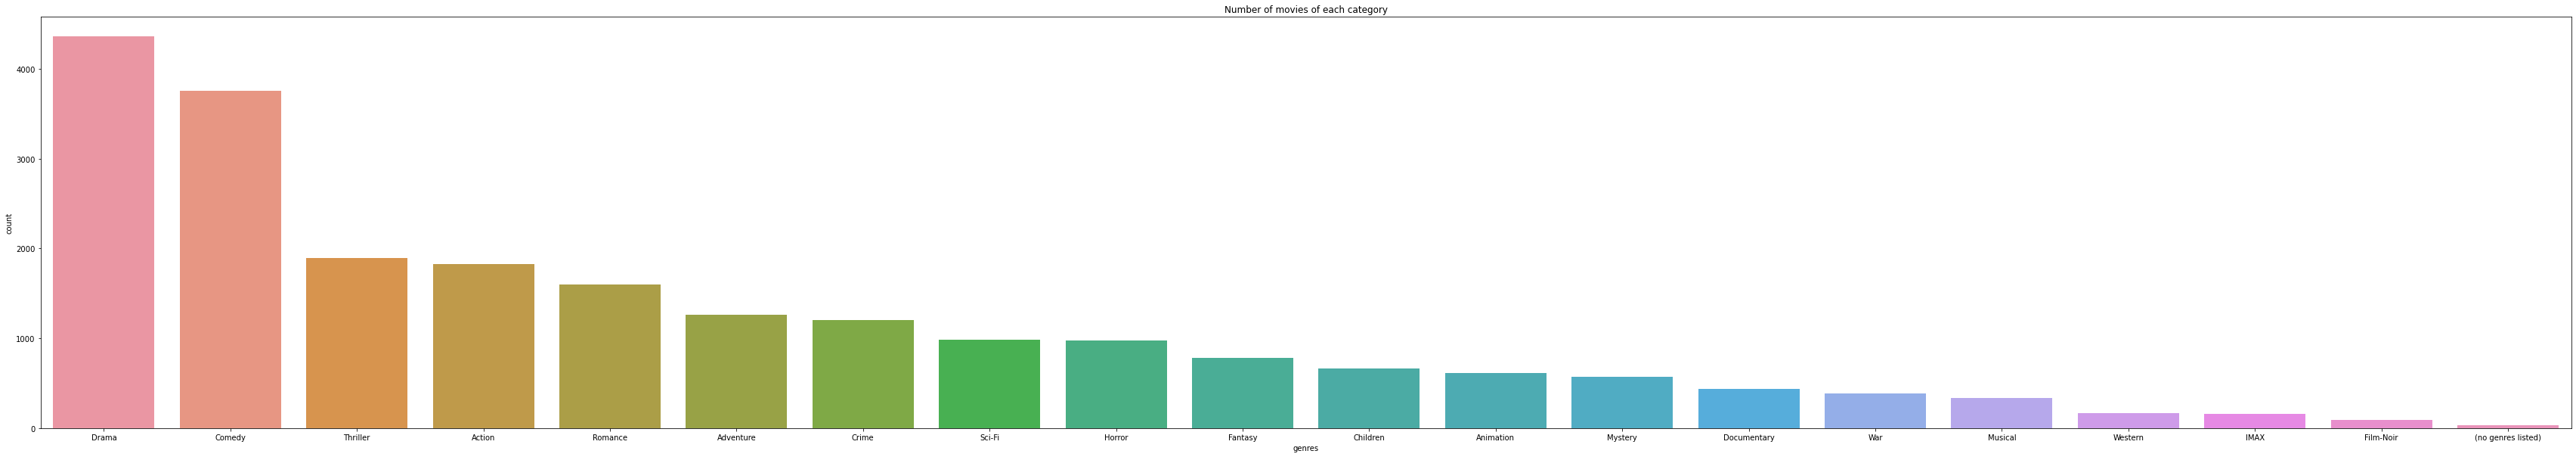

In [19]:
# analysis movies by content
movies_genres_temp = movies_df.where('genres is not null')\
.select('title', F.explode(F.split('genres', '\|')).alias('genres'))

movies_genres = movies_genres_temp.groupBy('genres').count()\
.orderBy('count', ascending=False)\
.toPandas()

fig = plt.figure(figsize=(60,10))
tmp = sns.barplot(x='genres', y='count', data=movies_genres)
tmp.set_title('Number of movies of each category')
display(tmp)

<AxesSubplot:title={'center':'Number of movies of each rating'}, xlabel='rating', ylabel='count'>

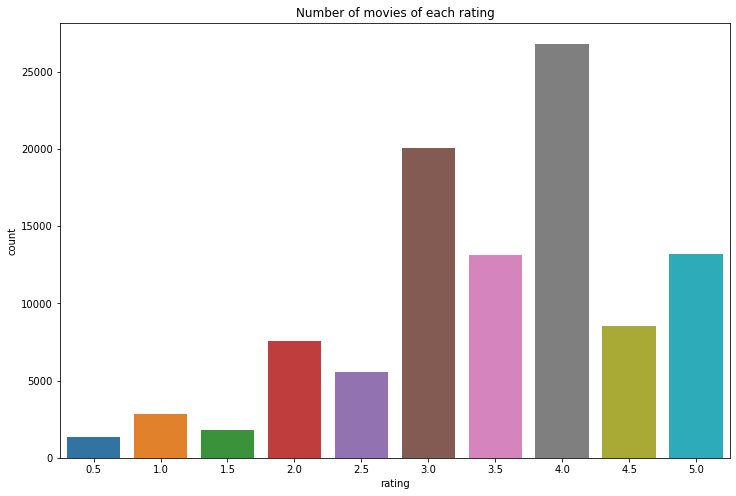

In [20]:
# get statistics for ratings
ratings_result = ratings_df.groupBy('rating').count()\
.withColumn('rating', ratings_df.rating.cast('float'))\
.toPandas()

fig = plt.figure(figsize=(12,8))
tmp=sns.barplot(x='rating', y='count', data=ratings_result)
tmp.set_title('Number of movies of each rating')
display(tmp)

## Part 2: Spark SQL and OLAP

In [21]:
# Registers this DataFrame as a temporary table using the given name
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

### Q1: The number of Users

In [22]:
spark.sql('SELECT COUNT(distinct userID) \
           AS Number_of_users \
           FROM ratings').show()

+---------------+
|Number_of_users|
+---------------+
|            610|
+---------------+



### Q2: The number of Movies

In [23]:
spark.sql('SELECT COUNT(distinct movieId) \
           AS Numer_of_movies \
           FROM movies').show()

+---------------+
|Numer_of_movies|
+---------------+
|           9742|
+---------------+



### Q3:  How many movies are rated by users? List movies not rated before

In [24]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [25]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [26]:
spark.sql('SELECT COUNT(distinct movieId) \
           AS Numer_of_movies_rated_by_user \
           FROM ratings').show()

+-----------------------------+
|Numer_of_movies_rated_by_user|
+-----------------------------+
|                         9724|
+-----------------------------+



In [27]:
spark.sql('SELECT m.title, m.genres \
           FROM movies m LEFT JOIN ratings r ON m.movieID=r.movieID \
           WHERE r.rating is null').show()

+--------------------+--------------------+
|               title|              genres|
+--------------------+--------------------+
|Innocents, The (1...|Drama|Horror|Thri...|
|      Niagara (1953)|      Drama|Thriller|
|For All Mankind (...|         Documentary|
|Color of Paradise...|               Drama|
|I Know Where I'm ...|   Drama|Romance|War|
|  Chosen, The (1981)|               Drama|
|Road Home, The (W...|       Drama|Romance|
|      Scrooge (1970)|Drama|Fantasy|Mus...|
|        Proof (1991)|Comedy|Drama|Romance|
|Parallax View, Th...|            Thriller|
|This Gun for Hire...|Crime|Film-Noir|T...|
|Roaring Twenties,...|Crime|Drama|Thriller|
|Mutiny on the Bou...|Adventure|Drama|R...|
|In the Realms of ...|Animation|Documen...|
|Twentieth Century...|              Comedy|
|Call Northside 77...|Crime|Drama|Film-...|
|Browning Version,...|               Drama|
|  Chalet Girl (2011)|      Comedy|Romance|
+--------------------+--------------------+



### Q4: List Movie Genres

In [28]:
spark.sql('SELECT distinct genres \
           FROM movies').show()

+--------------------+
|              genres|
+--------------------+
|Comedy|Horror|Thr...|
|Adventure|Sci-Fi|...|
|Action|Adventure|...|
| Action|Drama|Horror|
|Action|Animation|...|
|Animation|Childre...|
|Action|Adventure|...|
|    Adventure|Sci-Fi|
|Documentary|Music...|
|Adventure|Childre...|
| Adventure|Animation|
| Musical|Romance|War|
|Action|Adventure|...|
|Adventure|Childre...|
|Comedy|Crime|Horr...|
|Crime|Drama|Fanta...|
|Comedy|Mystery|Th...|
|   Adventure|Fantasy|
|Horror|Romance|Sc...|
|Drama|Film-Noir|R...|
+--------------------+
only showing top 20 rows



### Q5: Movie for Each Category

In [29]:
spark.sql('SELECT distinct Category \
           FROM movies \
           LATERAL VIEW explode(split(genres, "[|]")) \
           AS Category \
           ORDER BY Category').show()

+------------------+
|          Category|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



In [30]:
spark.sql('SELECT Category, COUNT(movieID) AS Numbers\
           FROM movies \
           LATERAL VIEW explode(split(genres, "[|]")) \
           AS Category \
           GROUP BY Category \
           ORDER BY Numbers DESC').show()

+------------------+-------+
|          Category|Numbers|
+------------------+-------+
|             Drama|   4361|
|            Comedy|   3756|
|          Thriller|   1894|
|            Action|   1828|
|           Romance|   1596|
|         Adventure|   1263|
|             Crime|   1199|
|            Sci-Fi|    980|
|            Horror|    978|
|           Fantasy|    779|
|          Children|    664|
|         Animation|    611|
|           Mystery|    573|
|       Documentary|    440|
|               War|    382|
|           Musical|    334|
|           Western|    167|
|              IMAX|    158|
|         Film-Noir|     87|
|(no genres listed)|     34|
+------------------+-------+



In [31]:
spark.sql('SELECT Category, title \
           FROM movies \
           LATERAL VIEW explode(split(genres, "[|]")) \
           AS Category \
           GROUP BY Category,title').show()

+---------+--------------------+
| Category|               title|
+---------+--------------------+
|    Drama|  Money Train (1995)|
| Thriller|Usual Suspects, T...|
|Animation|Snow White and th...|
|   Comedy| Pretty Woman (1990)|
|Adventure|Bedknobs and Broo...|
| Thriller|Touch of Evil (1958)|
|   Horror|   Body Parts (1991)|
|   Comedy|     In & Out (1997)|
|    Crime|King of New York ...|
|    Drama|Dream for an Inso...|
| Children|Apple Dumpling Ga...|
|    Drama|Love Is the Devil...|
|    Drama|American History ...|
|   Comedy|Hard Core Logo (1...|
|   Action| Superman III (1983)|
|   Horror|    Tarantula (1955)|
|  Mystery|Red Violin, The (...|
| Thriller|Tequila Sunrise (...|
|    Drama|    Hairspray (1988)|
|   Sci-Fi| Galaxy Quest (1999)|
+---------+--------------------+
only showing top 20 rows



In [32]:
lists_of_movies_per_category = spark.sql('SELECT t.Category, CONCAT_WS(",", COLLECT_SET(t.title)) AS lists_of_movies\
           FROM \
           ( \
           SELECT Category, title \
           FROM movies \
           LATERAL VIEW explode(split(genres, "[|]")) \
           AS Category \
           GROUP BY Category, title \
           ) AS t \
           GROUP BY t.Category')

lists_of_movies_per_category.show()

+------------------+--------------------+
|          Category|     lists_of_movies|
+------------------+--------------------+
|             Crime|Stealing Rembrand...|
|           Romance|Vampire in Brookl...|
|          Thriller|Element of Crime,...|
|         Adventure|Ice Age: Collisio...|
|             Drama|Airport '77 (1977...|
|               War|General, The (192...|
|       Documentary|Jim & Andy: The G...|
|           Fantasy|Masters of the Un...|
|           Mystery|Before and After ...|
|           Musical|U2: Rattle and Hu...|
|         Animation|Ice Age: Collisio...|
|         Film-Noir|Rififi (Du rififi...|
|(no genres listed)|T2 3-D: Battle Ac...|
|              IMAX|Harry Potter and ...|
|            Horror|Tormented (1960),...|
|           Western|Man Who Shot Libe...|
|            Comedy|Hysteria (2011),H...|
|          Children|Ice Age: Collisio...|
|            Action|Stealing Rembrand...|
|            Sci-Fi|Push (2009),SORI:...|
+------------------+--------------

In [33]:
lists_of_movies_per_category.toPandas()

,Category,lists_of_movies
0,Crime,"Stealing Rembrandt (Rembrandt) (2003),The Gamb..."
1,Romance,"Vampire in Brooklyn (1995),Hysteria (2011),Far..."
2,Thriller,"Element of Crime, The (Forbrydelsens Element) ..."
3,Adventure,"Ice Age: Collision Course (2016),Masters of th..."
4,Drama,"Airport '77 (1977),Element of Crime, The (Forb..."
5,War,"General, The (1926),Joyeux Noël (Merry Christm..."
6,Documentary,"Jim & Andy: The Great Beyond (2017),U2: Rattle..."
7,Fantasy,"Masters of the Universe (1987),Odd Life of Tim..."
8,Mystery,"Before and After (1996),Primal Fear (1996),'Sa..."
9,Musical,"U2: Rattle and Hum (1988),Sword in the Stone, ..."


### Q6: Number of ratings per user

In [34]:
spark.sql('SELECT userID, COUNT(rating) AS Number_of_ratings \
           FROM ratings \
           GROUP BY userID \
           ORDER BY Number_of_ratings DESC').show()

+------+-----------------+
|userID|Number_of_ratings|
+------+-----------------+
|   414|             2698|
|   599|             2478|
|   474|             2108|
|   448|             1864|
|   274|             1346|
|   610|             1302|
|    68|             1260|
|   380|             1218|
|   606|             1115|
|   288|             1055|
|   249|             1046|
|   387|             1027|
|   182|              977|
|   307|              975|
|   603|              943|
|   298|              939|
|   177|              904|
|   318|              879|
|   232|              862|
|   480|              836|
+------+-----------------+
only showing top 20 rows



### Q7: Number of ratings per movie

In [35]:
spark.sql('SELECT movieID, COUNT(rating) AS Number_of_ratings \
           FROM ratings \
           GROUP BY movieID \
           ORDER BY Number_of_ratings DESC').show()

+-------+-----------------+
|movieID|Number_of_ratings|
+-------+-----------------+
|    356|              329|
|    318|              317|
|    296|              307|
|    593|              279|
|   2571|              278|
|    260|              251|
|    480|              238|
|    110|              237|
|    589|              224|
|    527|              220|
|   2959|              218|
|      1|              215|
|   1196|              211|
|   2858|              204|
|     50|              204|
|     47|              203|
|    780|              202|
|    150|              201|
|   1198|              200|
|   4993|              198|
+-------+-----------------+
only showing top 20 rows



### Q8: Number of movies each rating

In [36]:
spark.sql('SELECT rating, COUNT(movieID) AS Number_of_movies \
           FROM ratings \
           GROUP BY rating \
           ORDER BY Number_of_movies DESC').show()

+------+----------------+
|rating|Number_of_movies|
+------+----------------+
|   4.0|           26818|
|   3.0|           20047|
|   5.0|           13211|
|   3.5|           13136|
|   4.5|            8551|
|   2.0|            7551|
|   2.5|            5550|
|   1.0|            2811|
|   1.5|            1791|
|   0.5|            1370|
+------+----------------+



## Part 3: Spark ALS based approach for training model
We will use an Spark ML to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

In [37]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [38]:
ratings_df.schema

StructType(List(StructField(userId,StringType,true),StructField(movieId,StringType,true),StructField(rating,StringType,true),StructField(timestamp,StringType,true)))

In [39]:
movie_ratings=ratings_df.drop('timestamp')

In [40]:
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [41]:
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



In [42]:
movie_ratings.schema

StructType(List(StructField(userId,IntegerType,true),StructField(movieId,IntegerType,true),StructField(rating,FloatType,true)))

In [43]:
movie_ratings.toPandas().head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### ALS Model, Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

The alternating least squares (ALS) algorithm factorizes a given matrix R into two factors U and V such that R≈UTV. The unknown row dimension is given as a parameter to the algorithm and is called latent factors. Since matrix factorization can be used in the context of recommendation, the matrices U and V can be called user and item matrix, respectively. The ith column of the user matrix is denoted by u and the ith column of the item matrix is vi. The matrix R can be called the ratings matrix with (R)i,j=ri,j.

In [44]:
# import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [45]:
# Create test and train set
(training,test)=movie_ratings.randomSplit([0.8,0.2])

In [46]:
# Create ALS model
als = ALS(maxIter=5, rank=10, 
          regParam=0.01, userCol="userId", 
          itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")

# als model for refitting
#als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

In [47]:
# Tune model using ParamGridBuilder
paramGrid = ParamGridBuilder()\
            .addGrid(als.regParam, [0.1, 0.01, 0.001])\
            .addGrid(als.maxIter, [3, 5, 10])\
            .addGrid(als.rank, [5, 10, 15])\
            .build()

In [48]:
# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [49]:
# Build Cross validation 
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

In [50]:
# Fit ALS model to training data
model = als.fit(training)
predictions = model.transform(training)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.5041225853413313


In [51]:
# Extract best model from the tuning exercise using ParamGridBuilder
cvModel = crossval.fit(training)
predictions = cvModel.transform(training)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.6384267293651439


### Model testing
And finally, make a prediction and check the testing error.

In [52]:
# Generate predictions and evaluate using RMSE
best_model = cvModel.bestModel
predictions=best_model.transform(test)
rmse = evaluator.evaluate(predictions)

In [53]:
# Print evaluation metrics and model parameters
print ("RMSE = "+str(rmse))
print ("** Best Model **")
print (" Rank: "+str(best_model._java_obj.parent().getRank())), 
print (" MaxIter: "+str(best_model._java_obj.parent().getMaxIter())), 
print (" RegParam: "+str(best_model._java_obj.parent().getRegParam()))

RMSE = 0.8839192092830443
** Best Model **
 Rank: 5
 MaxIter: 10
 RegParam: 0.1


In [54]:
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   610|    471|   4.0|  3.548472|
|   555|    471|   3.0| 3.6636455|
|   171|    471|   3.0|  4.306225|
|   287|    471|   4.5|  2.147298|
|   469|    471|   5.0|  3.511252|
|   159|   1088|   4.0| 3.2926195|
|   177|   1088|   3.5| 3.5520046|
|   286|   1088|   3.5| 3.3187864|
|   583|   1088|   3.5|  3.508195|
|   391|   1088|   1.0| 2.7930572|
|    68|   1088|   3.5|  3.488113|
|   104|   1088|   3.0| 3.7940018|
|   268|   1238|   5.0| 3.8081765|
|   462|   1238|   3.5| 3.7400713|
|   156|   1238|   4.0|  3.812151|
|   325|   1342|   4.0| 2.3232017|
|   137|   1580|   3.5|  3.300006|
|   322|   1580|   3.5|  3.111376|
|    34|   1580|   2.5|  3.301279|
|   368|   1580|   3.0|  2.931051|
+------+-------+------+----------+
only showing top 20 rows



In [55]:
predictions_temp = predictions.toPandas()
predictions_temp.head()

,userId,movieId,rating,prediction
0,610,471,4.0,3.548472
1,555,471,3.0,3.663646
2,171,471,3.0,4.306225
3,287,471,4.5,2.147298
4,469,471,5.0,3.511252


Text(0.5, 0.92, 'Actual & predicted rating by users and movie ID')

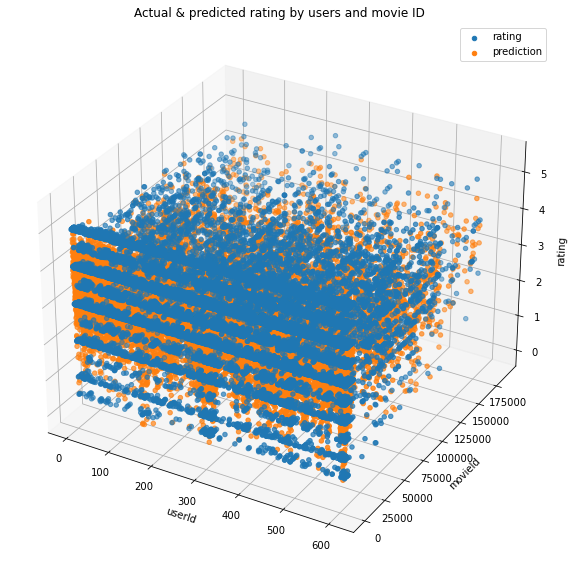

In [56]:
# Plot all ratings and predicted ratings by users and movies
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
x = predictions_temp['userId']
y = predictions_temp['movieId']
z = predictions_temp['rating']
w = predictions_temp['prediction']

ax.scatter(x, y, z, label='rating')
ax.scatter(x, y, w, label='prediction')
ax.legend()
ax.set_xlabel('userId')
ax.set_ylabel('movieId')
ax.set_zlabel('rating')
ax.set_title('Actual & predicted rating by users and movie ID')

## Part 4: Model apply to all data and see the performance

In [57]:
alldata_prediction = best_model.transform(movie_ratings)
rmse = evaluator.evaluate(alldata_prediction)
print("RMSE = "+str(rmse))

RMSE = 0.6929072606547774


In [58]:
# Re-fitting using new best parameters and whole data set
#new_als = ALS(maxIter=10, regParam=0.01, rank=5, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
#new_model = new_als.fit(movie_ratings)
#predictions = new_model.transform(test)
#rmse = evaluator.evaluate(predictions)
#print ("RMSE = "+str(rmse))

In [77]:
#round predictions to 0.5
alldata_prediction = alldata_prediction.withColumn('rounded_predictions', F.round(F.col('prediction')*2)/2)
alldata_prediction_temp = alldata_prediction.toPandas()
alldata_prediction_temp.head()

,userId,movieId,rating,prediction,rounded_predictions
0,191,148,5.0,4.924200,5.0
1,133,471,4.0,3.028732,3.0
2,597,471,2.0,4.004687,4.0
3,385,471,4.0,3.069793,3.0
4,436,471,3.0,3.457296,3.5


In [78]:
alldata_prediction.registerTempTable("alldata_prediction")

In [79]:
spark.sql('SELECT * FROM alldata_prediction').show()

+------+-------+------+----------+-------------------+
|userId|movieId|rating|prediction|rounded_predictions|
+------+-------+------+----------+-------------------+
|   191|    148|   5.0| 4.9241996|                5.0|
|   133|    471|   4.0| 3.0287318|                3.0|
|   597|    471|   2.0|  4.004687|                4.0|
|   385|    471|   4.0| 3.0697927|                3.0|
|   436|    471|   3.0|  3.457296|                3.5|
|   602|    471|   4.0| 3.4959733|                3.5|
|    91|    471|   1.0| 2.6207905|                2.5|
|   409|    471|   3.0| 3.2339196|                3.0|
|   372|    471|   3.0| 3.5251846|                3.5|
|   599|    471|   2.5| 2.6651316|                2.5|
|   603|    471|   4.0| 3.4729586|                3.5|
|   182|    471|   4.5|  3.355753|                3.5|
|   218|    471|   4.0| 3.1126418|                3.0|
|   474|    471|   3.0| 3.6338792|                3.5|
|   500|    471|   1.0| 2.0731447|                2.0|
|    57|  

In [80]:
spark.sql('SELECT * FROM movies \
          JOIN alldata_prediction on movies.movieId=alldata_prediction.movieId').show()

+-------+--------------------+------+------+-------+------+----------+-------------------+
|movieId|               title|genres|userId|movieId|rating|prediction|rounded_predictions|
+-------+--------------------+------+------+-------+------+----------+-------------------+
|    148|Awfully Big Adven...| Drama|   191|    148|   5.0| 4.9241996|                5.0|
|    471|Hudsucker Proxy, ...|Comedy|   133|    471|   4.0| 3.0287318|                3.0|
|    471|Hudsucker Proxy, ...|Comedy|   597|    471|   2.0|  4.004687|                4.0|
|    471|Hudsucker Proxy, ...|Comedy|   385|    471|   4.0| 3.0697927|                3.0|
|    471|Hudsucker Proxy, ...|Comedy|   436|    471|   3.0|  3.457296|                3.5|
|    471|Hudsucker Proxy, ...|Comedy|   602|    471|   4.0| 3.4959733|                3.5|
|    471|Hudsucker Proxy, ...|Comedy|    91|    471|   1.0| 2.6207905|                2.5|
|    471|Hudsucker Proxy, ...|Comedy|   409|    471|   3.0| 3.2339196|                3.0|

## Part 5: Application

### Recommend moive to users with id: 575, 232. 
you can choose some users to recommend the moives 

In [62]:
user_list=set(['575'])

# returns top num items recommended for each user, for all users.
recommend_for_user575 =best_model.recommendForAllUsers(20)

recommend_movieID = recommend_for_user575.where(recommend_for_user575.userId.isin(user_list))\
.select('userId', F.explode('recommendations'))\
.select('userId', F.col('col').movieId.alias('movieId'), F.col('col').rating.alias('rating'))

recommend_movieID = recommend_movieID.join(movies_df, recommend_movieID.movieId==movies_df.movieId, 'left')\
.select('userId', movies_df.movieId, 'title','genres')

recommend_movieID = recommend_movieID.join(movies_result, recommend_movieID.movieId==movies_result.movieId, 'left')

recommend_movieID.show()

+------+-------+--------------------+--------------------+-------+-----+
|userId|movieId|               title|              genres|movieId|count|
+------+-------+--------------------+--------------------+-------+-----+
|   575|  89759|Separation, A (Jo...|               Drama|  89759|    3|
|   575|   6650|Kind Hearts and C...|        Comedy|Drama|   6650|    3|
|   575|   1284|Big Sleep, The (1...|Crime|Film-Noir|M...|   1284|   14|
|   575|   3925|Stranger Than Par...|        Comedy|Drama|   3925|    6|
|   575|    417|    Barcelona (1994)|      Comedy|Romance|    417|   13|
|   575|  69524|Raiders of the Lo...|Action|Adventure|...|  69524|    3|
|   575|  26326|Holy Mountain, Th...|               Drama|  26326|    2|
|   575|     40|Cry, the Beloved ...|               Drama|     40|    2|
|   575|  88448|Paper Birds (Pája...|        Comedy|Drama|  88448|    1|
|   575|   6442| Belle époque (1992)|      Comedy|Romance|   6442|    2|
|   575|    665|  Underground (1995)|    Comedy|Dra

In [63]:
user_list=set(['232'])

# returns top num items recommended for each user, for all users.
recommend_for_user232 =best_model.recommendForAllUsers(20)

recommend_movieID = recommend_for_user232.where(recommend_for_user232.userId.isin(user_list))\
.select('userId', F.explode('recommendations'))\
.select('userId', F.col('col').movieId.alias('movieId'), F.col('col').rating.alias('rating'))

recommend_movieID = recommend_movieID.join(movies_df, recommend_movieID.movieId==movies_df.movieId, 'left')\
.select('userId', movies_df.movieId, 'title','genres')

recommend_movieID = recommend_movieID.join(movies_result, recommend_movieID.movieId==movies_result.movieId, 'left')

recommend_movieID.show()

+------+-------+--------------------+--------------------+-------+-----+
|userId|movieId|               title|              genres|movieId|count|
+------+-------+--------------------+--------------------+-------+-----+
|   232|   5607|Son of the Bride ...|        Comedy|Drama|   5607|    1|
|   232| 134796|  Bitter Lake (2015)|         Documentary| 134796|    1|
|   232| 117531|    Watermark (2014)|         Documentary| 117531|    1|
|   232| 179135|Blue Planet II (2...|         Documentary| 179135|    1|
|   232|  84273|Zeitgeist: Moving...|         Documentary|  84273|    1|
|   232| 138966|Nasu: Summer in A...|           Animation| 138966|    1|
|   232|  26073|Human Condition I...|           Drama|War|  26073|    1|
|   232|  93008|Very Potter Seque...|      Comedy|Musical|  93008|    1|
|   232|  25906|Mr. Skeffington (...|       Drama|Romance|  25906|    1|
|   232|   3451|Guess Who's Comin...|               Drama|   3451|   11|
|   232|   3925|Stranger Than Par...|        Comedy

### Find the similar moives for moive with id: 463, 471
You can find the similar moives based on the ALS results

word embeding：转化成两个向量

### movie ID: 471

In [64]:
all_movie_id = ratings_df.select('movieId').distinct()
is_rated = all_movie_id.where('movieId=471').count()>=1

print('Movie with id 471 was rated? {}'.format(is_rated))

Movie with id 471 was rated? True


In [65]:
item_factors = best_model.itemFactors
movie_factors = item_factors.to_koalas()
movie_factors.head()

,id,features
0,10,"[0.917360782623291, -0.8065869212150574, 0.185..."
1,20,"[0.4749511182308197, -0.5005270838737488, -0.1..."
2,30,"[-0.3387099802494049, 0.5249912738800049, 0.43..."
3,40,"[0.3421698212623596, -0.8855372071266174, 0.12..."
4,50,"[0.6848330497741699, -0.4628043472766876, 0.43..."


In [66]:
# item factors cross join table with feature movieID
item_factors_table = item_factors.select('id', 'features').where('id = 471'). \
                     withColumnRenamed('id', 'id1').withColumnRenamed('features', 'f1'). \
                     crossJoin(item_factors.select('id', 'features').where('id != 471').  \
                              withColumnRenamed('id', 'id2').withColumnRenamed('features', 'f2'))
item_factors_table.toPandas().head()

,id1,f1,id2,f2
0,471,"[1.5207722187042236, -0.443275511264801, 0.152...",10,"[0.917360782623291, -0.8065869212150574, 0.185..."
1,471,"[1.5207722187042236, -0.443275511264801, 0.152...",20,"[0.4749511182308197, -0.5005270838737488, -0.1..."
2,471,"[1.5207722187042236, -0.443275511264801, 0.152...",30,"[-0.3387099802494049, 0.5249912738800049, 0.43..."
3,471,"[1.5207722187042236, -0.443275511264801, 0.152...",40,"[0.3421698212623596, -0.8855372071266174, 0.12..."
4,471,"[1.5207722187042236, -0.443275511264801, 0.152...",50,"[0.6848330497741699, -0.4628043472766876, 0.43..."


In [67]:
# define cosine similarity
def cos_similarity(target_id_feature, feature):
    return float(np.dot(target_id_feature,feature) / (np.linalg.norm(target_id_feature) * np.linalg.norm(feature)))

# creates a user defined function (UDF)
cosine_similarity = udf(cos_similarity, FloatType())

In [75]:
similar_moives = item_factors_table.withColumn('similarity', 
                                               cosine_similarity(F.col('f1'), F.col('f2'))). \
                                    where('similarity>=0.997'). \
                                    orderBy('similarity', ascending=False)
similar_moives = similar_moives.join(movies_df, 
                                     movies_df.movieId==similar_moives.id2,'left'). \
                                select('title','genres')
similar_moives.show()

+--------------------+--------------------+
|               title|              genres|
+--------------------+--------------------+
| Just My Luck (2006)|      Comedy|Romance|
|Sisterhood of the...|Adventure|Comedy|...|
|My Life in Ruins ...|              Comedy|
|      Beastly (2011)|Drama|Fantasy|Rom...|
|The Last Five Yea...|Comedy|Drama|Musi...|
|Last Song, The (2...|       Drama|Romance|
|Back-up Plan, The...|      Comedy|Romance|
|    Abduction (2011)|Action|Drama|Myst...|
|   Bride Wars (2009)|      Comedy|Romance|
|Lucky One, The (2...|               Drama|
|          LOL (2012)|Comedy|Drama|Romance|
|Material Girls (2...|Children|Comedy|D...|
|Ghosts of Girlfri...|Comedy|Fantasy|Ro...|
|   Safe Haven (2013)|Drama|Mystery|Rom...|
|  Love, Rosie (2014)|      Comedy|Romance|
|Angus, Thongs and...|      Comedy|Romance|
|Couples Retreat (...|      Comedy|Romance|
|    You Again (2010)|              Comedy|
|Did You Hear Abou...|Comedy|Crime|Dram...|
|What to Expect Wh...|Comedy|Dra

### movie ID: 463

In [81]:
all_movie_id = ratings_df.select('movieId').distinct()
is_rated = all_movie_id.where('movieId=463').count()>=1

print('Movie with id 463 was rated? {}'.format(is_rated))

Movie with id 463 was rated? False


In [83]:
# Special groups
average_by_user = alldata_prediction.groupBy('userId'). \
                  agg(F.mean(F.abs(alldata_prediction.rating-alldata_prediction.rounded_predictions)). \
                             alias('MEBU'), 
                      F.count('rating').alias('number_of_movies_rated')). \
                  orderBy('MEBU', ascending=False)

average_by_user.where('MEBU>0.8').show()

+------+------------------+----------------------+
|userId|              MEBU|number_of_movies_rated|
+------+------------------+----------------------+
|   259|1.0862068965517242|                    29|
|   461|0.9814814814814815|                    27|
|    55|              0.98|                    25|
|   149|0.9310344827586207|                    58|
|   399|0.9305555555555556|                    36|
|   542| 0.915929203539823|                   113|
|    22|0.9117647058823529|                   119|
|    34|0.8953488372093024|                    86|
|   536|            0.8875|                    40|
|    77|0.8793103448275862|                    29|
|   328|0.8705882352941177|                   255|
|   329|0.8695652173913043|                    23|
|   308|0.8695652173913043|                   115|
|   115|0.8660714285714286|                   112|
|    81|0.8653846153846154|                    26|
|    31|              0.85|                    50|
|   393|0.8414634146341463|    

## 2.Write the report 
During my daily life, I'm not quite satisfied with many recommended music and movies provided by some apps and websites, even those from Big Names like Youtube and Netflix. As a data scientist candidate, I would like to improve those recommendation systems in the future if I have a chance. Before that, I need to have a general and basic idea about how the most common and popular recommendation systems work. So I tried my best to build a simple recommendation system on a small dataset. 
<br>
1. Conduct exploratory data analysis like split genres into categories, count the number of movies under each category, etc.
2. Build a recommendation model based on historical movie ratings and solve it by matrix factorization and alternating least squares (ALS). 
3. Tune the model parameters through grid search and crossvalidation with the metric root mean square errors (rmse). The optimal model has rmse = 0.64 on the training dataset and rmse = 0.889 on the test dataset.
4. Recommend 10 movies to some certain users and find top 10 similar movies in terms of some specific movies.

The best model I got has 5 latent factors (hidden features). These features describe a movie in 5 dimensions. Based on the feature, I can define the similarity between movies.<br>
In this model, I droped all unseen items and/or items during training process. The evaluation metric was computed over the non-NaN data and so, was valid.
<br>
I tried twice to run it on the large dataset for the whole night. Maybe due to the community version, everytime when training the model more than 2 hours, my Spark broke down.
In the future, I will run this model on a much larger dataset.

## 3.Write the report 

**1. Motivation:**

Recommendation systems are widely used today by big companies such as Amazon, Youtube, and Netflix for their Internet products. A good recommendation system significantly increases their business values. In this work, ALS is used to build a recommendation system based on data from [grouplens](https://grouplens.org/datasets/movielens/latest/) (Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018.) 

**Data characteristics: **

A major data characteristic of training a recommendation system is high sparsity. Just consider how many purchased items you have ever rated. One thing to point out is that most products only have a small number of reviews, and a small number of products are heavily rated. Also, most ratings are written by the same small amount of users.

Another important data feature is that the number of movies is around 10 times larger than that of the users.

![image](https://github.com/RuiyunHuang/Movies_Recommendation_System/blob/master/images/user_dis.png)
![image](https://github.com/RuiyunHuang/Movies_Recommendation_System/blob/master/images/movie_dis.png)

**Why ALS?: **

Alternating Least Square (ALS) Matrix Factorization is an intermediary along the pathway of developing recommendation systems and is widely used by many companies. The key characteristic of this approach is a combination of good scalability and predictive accuracy. A detailed description can be found on [Standford CME323](http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf) and [NETFLIX-recommender systems](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf)

**2. Implementation:**

**Step.1 Data Exploration and Observations**

The source data is relatively clean. Three data tables are complete with the only table (links.csv) having null values. This table is also not related to the major work here currently. We will focus on the ratings.csv table since it contains the most important information for data training, and then the movies.csv as it provides more perspectives on the movie's content for users.

As expected, extreme cases for both users and movies are observed as mentioned above. The 'long-tail' characteristic is clearly present as the spasticity of the “user vs. item” matrix is as high as 0.983. 

**Step.2 Training and model selection**

The parameters that need tuning are rank (how many latent features for each user and movie), regParam (regulation parameter), and maxIter (max iteration). Grid search and cross-validation are used. Final parameters are determined and then used for training the whole set of data.

**Step.3 Analysis**

To compare the actual data and the predicted data, the first step is to round the predicted score to 0.5. (Follow with table) Then as all ratings are plotted against the userId and movie Id, I found the graph too messy. (Follow with graph) Here, we are looking at the mean square error for 4 special cases (users rated most and least movies, and movies with most and least users) for a better understanding of the result. 

![image](https://github.com/RuiyunHuang/Movies_Recommendation_System/blob/master/images/rounded_ratings.png)

| MSE | User  | Movie |
| -- | -- | -- |
| Most | 0.578 | 0.571 |
| Least  | 0.748 | 0.021 |

In terms of users, the prediction for who are more active users is better than that for who are less active, which is intuitively right. However, in terms of movies, it is surprising to find out that the prediction for movies’s ratings with the most number of ratings is far worse than that for movies with only one rating. This is also not due to the effect of averaging, which is  shown by the figures below. 

![image](https://github.com/RuiyunHuang/Movies_Recommendation_System/blob/master/images/most_by_movies.png)
![image](https://github.com/RuiyunHuang/Movies_Recommendation_System/blob/master/images/least_by_movies.png)

Though counterintuitive, this is easy to understand. Let's consider what the matrix factorization actually does. It is trying to guess the 'most likely' k-dimension features for each movie (m) and user (n) based on an n by m matrix with labeled ratings. 

![image](https://github.com/RuiyunHuang/Movies_Recommendation_System/blob/master/images/Matrix-Factorization.png)

First, let's consider a special case where we have one 4-star rating from one user for one movie. There are infinite combinations of results that can ensure 0 error, even when k=1. 

Then for a 2x2 table:

| rating (1-5) | movie 1 | movie 2 |
| -- | -- | -- |
| user 1 | 3 | 4 |
| user 2 | 1 | 5 |

If we set k=1, normally we can have solutions without error. That means we certainly know the taste of each user and the feature of each movie. If we lose one rating, to guess the rating by using matrix factorization for this missing value is very risky or actually invalid, because again there are infinite combinations of results. Increasing k would also lead to similar conclusion.

Based on the analysis above, we can quickly imagine a 1xn or an nx1 table will display the same result. So ideally, we need a reasonable 'activity' of movies and users which will ensure a higher correlation among users and movies. 

Further, it means that the categories of hidden k 'features' of one movie is not necessarily totally equal to those of other movies. It means we can not think of each row of the movie matrix as a certain feature, but hopefully, as the data and the correlation get large enough, the effect of those concerns would lessen.

As already reflected by the observations above, when averaged by the number of ratings, the absolute error is lower. At the same time, the error converges as the number of ratings gets to around 25. We can see that although the less-rated movies may be fitted better, it's more unstable. Therefore, ideally, I would recommend 50 to be the minimal number of ratings for movie to get fair results. 

![image](https://github.com/RuiyunHuang/Movies_Recommendation_System/blob/master/images/error_by_movie.png)
![image](https://github.com/RuiyunHuang/Movies_Recommendation_System/blob/master/images/error_by_movie_1.png)

**Step.4 Applications**

We can provide recommendations for users based on this model and find similar users or movies according to the cosine correlation of their latent features.

Beyond that, we should also pay special to attention to the users who are not represented well by the model (Also true for movies). 

**3. Conclusion**

Using ALS-based Matrix Factorization, I built a movie recommendation systems. The data displayed high sparsity and unbalanced ratio between the number users and movies. The latter could be a major reason for the unusual results above. 

Considering the application, I would recommend setting 50 as the threshold for the number of ratings for an optimal prediction for movies. It infers that we should actively encourage people to rate those movies which do not have this many reviews so far. Also, for those less-represented users and movies by the model, companies may want to take action to acquire more data or at least build a separate model for them.